# Hydrogeodesy: Monitoring surface waters from space
### Exercise 3: Comparison of different inland altimetry products

Daniel Scherer, DGFI-TUM  
Wintersemester 2022/23

**Contents**
1. Surface Area Estimation
2. Volume Variation with fixed area
3. Volume Variation with variable area

**Study Area: Lake Stamford (Texas, USA)**  
![AOI](aoi.jpg)  
*Figure 1: Satellite derived bathymetry of Lake Stamford*  
*[www.dahiti.dgfi.tum.de/10274]*  

Area Variation:        3 - 21km²  
Water Level Variation: 426 - 431m

Following data is used in this exercise:  
- Landsat 8 Scene LC08_L2SP_029037_20200613_20200823_02_T1
- Water level and
- Surface area time series from DAHITI [www.dahiti.dgfi.tum.de/10274]



First load some required modules:

In [1]:
from PIL import Image # Package for interacting with Image data
import numpy as np # fundamental package for scientific computing with Python
import matplotlib.pyplot as plt # standard plotting library
from scipy import ndimage
import scipy # collection of mathematical algorithms and convenience functions built on the numpy
import netCDF4 as nc # for reading netcdf data
import pandas as pd # For easy data analysis and manipulation

#### 1. Surface area estimation

![SWIR1](SWIR1_quicklook.jpg)
*Short Wave Infrared 1 band (SWIR1) quicklook**

![GREEN](GREEN_quicklook.jpg)
*Green band (GREEN) quicklook*

Load the required image bands:

In [2]:
# We convert the images to numpy arrays to be able to apply some calculations in the following
green = np.array(Image.open('Data/GREEN.tif')).astype(float)
swir1 = np.array(Image.open('Data/SWIR1.tif')).astype(float)

Calculate the Modified Normalized Difference Water Index (MNDWI):
$$ MNDWI = {GREEN - SWIR_1 \over GREEN + SWIR_1} $$

[*Hanqiu Xu (2006)* **Modification of normalised difference water index (NDWI) to enhance open water features in remotely sensed imagery**, International 
Journal of Remote Sensing, 27:14, 3025-3033, doi: 10.1080/01431160600589179]

In [3]:
mndwi = (green - swir1) / (green + swir1)

The MNDWI helps seperating water and land, so you should see two peaks in the following histogram. One for each type of landcover.

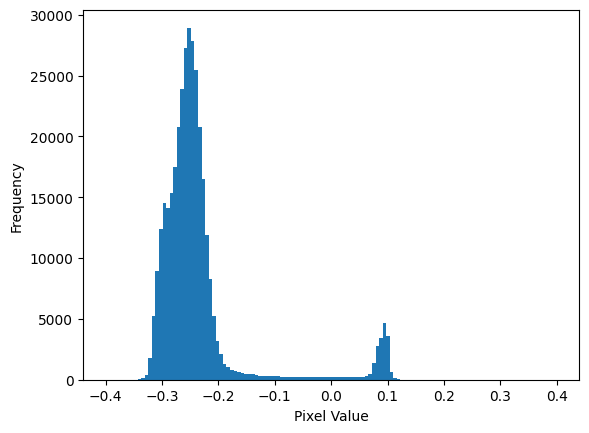

In [4]:
plt.hist(mndwi.flatten(),bins=np.linspace(-0.4,0.4,128))
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

Based on the histogram, choose an appropriate threshold value (th) to seperate water from land pixels:

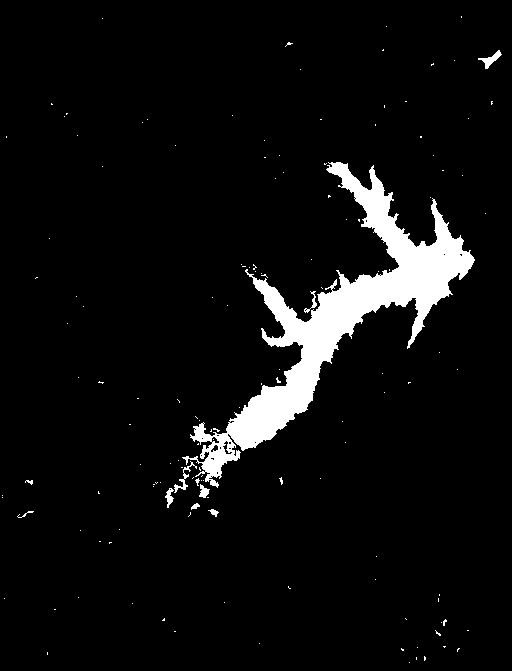

In [5]:
th = 0
water = mndwi > th # This returns us a boolean array where land pixels are False and water pixels are True
Image.fromarray(water)

Looking at the Image you should be able to recognize Lake Stamford. However, there are many small water bodies surrounding it, which we are not interested in.

Therefore we apply a labeling algorithm to isolate our target:

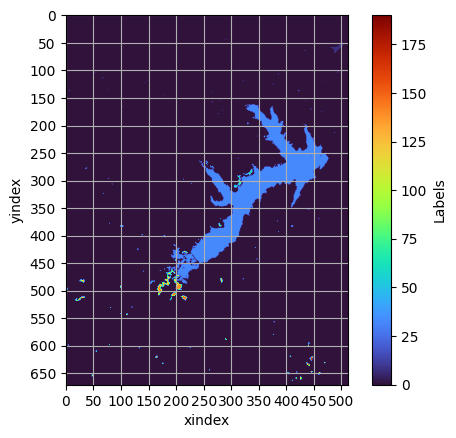

In [6]:
labels = ndimage.label(water)[0]
img = plt.imshow(labels,cmap="turbo")
plt.xlabel("xindex")
plt.ylabel('yindex')
plt.locator_params(nbins=20)
plt.grid()
plt.colorbar(img,label='Labels')
plt.show()

Based on the map of labels above, choose an appropiate pixel to sample the label of interest (within Lake Stamford)

You choosed label 33. Below you should see only Lake Stamford. Otherwise, try other coordinates.


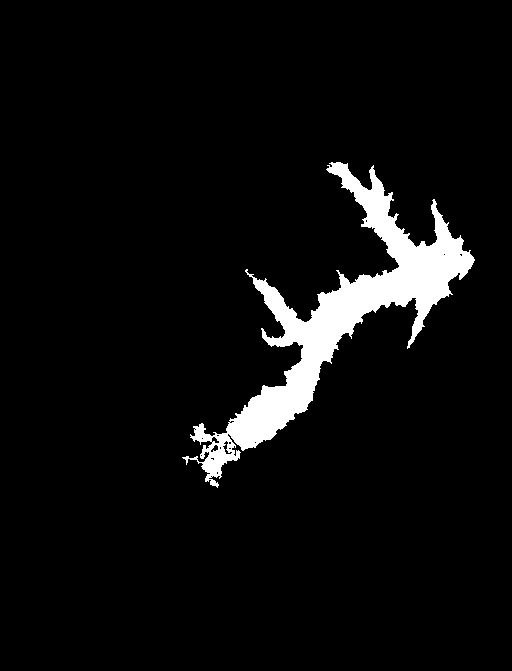

In [7]:
xindex = 350
yindex = 300
label_of_interest = labels[yindex,xindex] #Note, in the numpy array the x and y axes are switched around
print(f'You choosed label {label_of_interest}. Below you should see only Lake Stamford. Otherwise, try other coordinates.')
lake = labels == label_of_interest
Image.fromarray(lake)

**Calculate the static area of the lake.**  
(The ground resolution of Landsat 8 is approx. 30m.)

In [8]:
# np.sum(lake) gives you the number of true values in a boolean array.
area = np.sum(lake) * 30 * 30

#### 2. Volume variations with fixed area

1. Load the water level time series data:

In [9]:
dset = nc.Dataset('Data/10274_water_level_altimetry.nc')
# This is our series
water_level = pd.Series(data=dset['water_level'][:],index=pd.DatetimeIndex(dset['date'][:]))
dset.close()

Calculate the volume differences using the static area estimated above and the water level time series:

$$ \Delta V(t_{i-1},t_i) = (h_i - h_{i-1}) \cdot A $$

<AxesSubplot: ylabel='m3'>

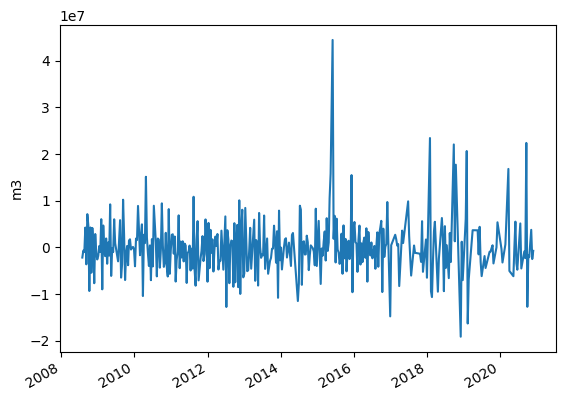

In [10]:
# You can use series.diff() to get the diffences between i and i-1
volume_differences = water_level.diff() * area
volume_differences.plot(ylabel='m3')

That is not so useful as it only shows the difference to the last time step.

Use the cumulative sum to get a volume variation time series.

<AxesSubplot: ylabel='m3'>

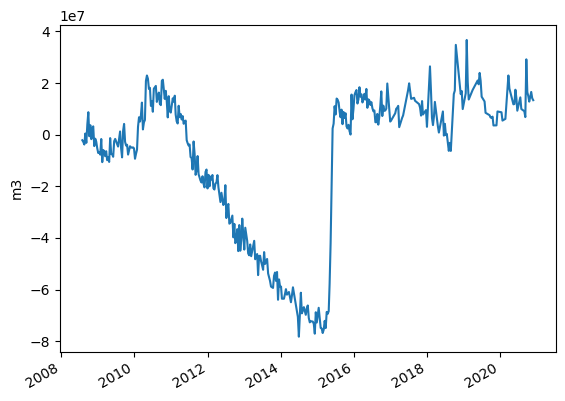

In [11]:
# Use series.cumsum()
volume_variation = volume_differences.cumsum()
volume_variation.plot(ylabel='m3')

Instead of a single Landsat Image, we can also use the average area from a long-term water occurrence mask as shown below:

![OCC](occ_mask.jpg)
*Long-term water occurence mask [dahiti.dgfi.tum.de/10274/water-occurrence-mask]*

Choose an appropiate occurrence value representing the average surface area:

In [12]:
occ_th = 50

We calculate a volume time series based on the occurrence mask and plot both results. Discuss the results.

Text(0, 0.5, 'Volume m3')

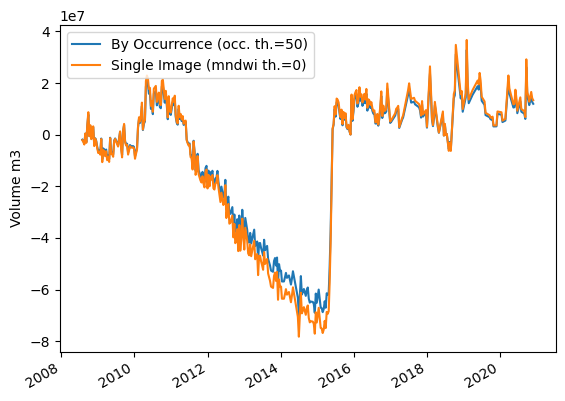

In [13]:
occ = np.array(Image.open('Data/10274_water_occurrence_mask.tif'))
# The pixel size is approx. 10x10m
occ_volume_variation = (((occ > occ_th).flatten().sum() * 10 * 10) * water_level.diff()).cumsum()
fig1, ax1 = plt.subplots()
occ_volume_variation.plot(ax=ax1,label=f'By Occurrence (occ. th.={occ_th})')
volume_variation.plot(ax=ax1,label=f'Single Image (mndwi th.={th})')
ax1.legend()
ax1.set_ylabel("Volume m3")

#### 3. Volume variations with variable area

A fixed area is not realistic, so now we will use a variable area derived from multiple Landsat Images.

Load the surface area time series

In [14]:
dset = nc.Dataset('Data/10274_surface_area.nc')
surface_area = pd.Series(data=dset['surface_area'][:],index=pd.DatetimeIndex(dset['date'][:]))
dset.close()

One challenge is that surface area and water level are not measured synchronously.  
The satellites carrying the different sensors pass the lake only rarely on the same date coincidently.

Use the following code to find and plot the synchronous measurements:

Text(0, 0.5, 'Water Level [m]')

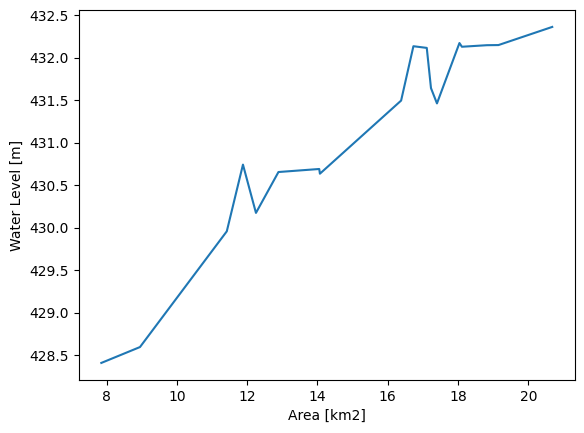

In [15]:
sync_idx = (surface_area.sort_values().index.intersection(water_level.index))
fig2, ax2 = plt.subplots()
ax2.plot(surface_area.loc[sync_idx],water_level.loc[sync_idx],label='synchronous')
ax2.set_xlabel("Area [km2]")
ax2.set_ylabel("Water Level [m]")

Interpolate the surface area data to match the water level dates:
- One possible solution is to simply interpolate the surface area data.
- Use the following code to get matching data and add the results to the plot above:

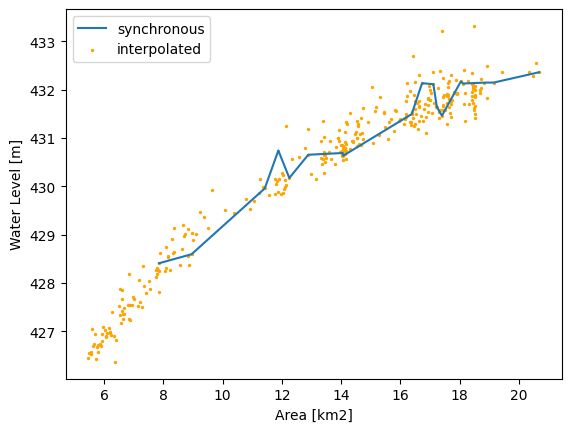

In [16]:
interp_area = surface_area.reindex(water_level.sort_index().index.join(surface_area.index,how='outer')).interpolate(limit_area='inside').reindex(water_level.index)
ax2.scatter(interp_area,water_level,s=2,color='orange',label='interpolated')
ax2.legend()
fig2

Discuss the quality of the interpolated data

Calculate the volume change between two observations with changing height and area using the pyramid formula:

$$
\Delta V\left(t_{i-1}, t_i\right)=\frac{1}{3}\left(h_i-h_{i-1}\right) \cdot\left(A_i+A_{i-1}+\sqrt{A_i \cdot A_{i-1}}\right)
$$

***Note that the input area is in km2!***

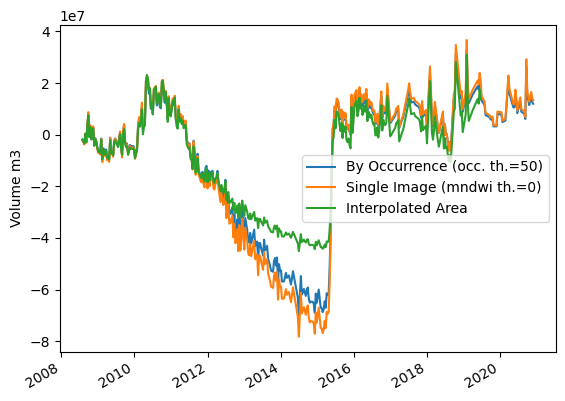

In [17]:
_interp_area = interp_area * 1e6
variable_volume = ((1/3) * water_level.diff() * (_interp_area.rolling(2).sum() + (_interp_area.rolling(2).apply(lambda x: x.product())).pow(1/2))).cumsum()
variable_volume.dropna(inplace=True) # We remove NaN values to avoid issues later
variable_volume.plot(ax=ax1,label='Interpolated Area')
ax1.legend()
fig1

Using a hypsometric function is a more sophisticated way to relate surface area and water level measurements.  
Below you can see the hypsometric function of Lake Stamford based on a function by Strahler (blue):
$$
y=\left[\frac{(0.01-x)}{(0.01-25.912)} \cdot \frac{(41.360-25.912)}{(41.360-x)}\right]^{0.093} \cdot 37.496+397.164
$$
In this case we derive the water level from the surface area.

![hypso](hypso.jpg)  

The hypsometric water levels derived using the above equation are already provided similar to the altimetric water levels we used before: 


In [69]:
dset = nc.Dataset('Data/10274_water_level_hypsometry.nc')
hypso_level = pd.Series(data=dset['water_level'][:],index=pd.DatetimeIndex(dset['date'][:]))
dset.close()

Calculate the volume change using the pyramid function from the non-interpolated surface area and the hypsomtric water level time series:

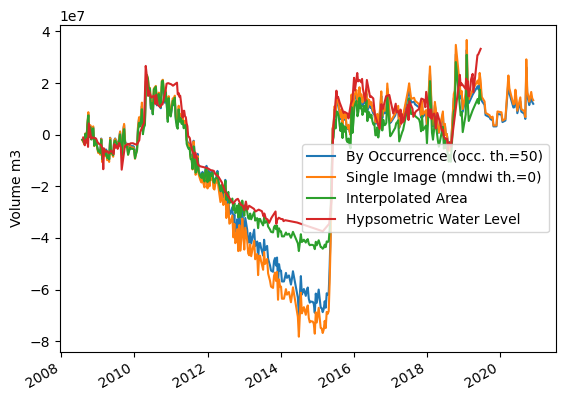

In [70]:
_hypso_level = hypso_level[hypso_level.index >= variable_volume.index.min()]
_surface_area = surface_area[surface_area.index >= variable_volume.index.min()] * 1e6
hypso_volume = ((1/3) * _hypso_level.diff() * (_surface_area.rolling(2).sum() + (_surface_area.rolling(2).apply(lambda x: x.product())).pow(1/2))).cumsum()
hypso_volume.plot(ax=ax1,label='Hypsometric Water Level')
ax1.legend()
fig1

Additionally, load the volume variation time series which uses a pixel accumulation
instead of the pyramid function:

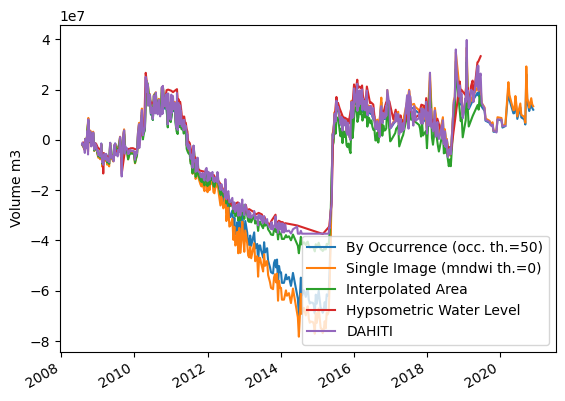

In [71]:
dset = nc.Dataset('Data/10274_volume_variation.nc')
dahiti_volume = pd.Series(data=dset['volume_variation'][:],index=pd.DatetimeIndex(dset['date'][:]))
dset.close()
dahiti_volume = dahiti_volume * 1e9
dahiti_volume = dahiti_volume[dahiti_volume.index >= variable_volume.index.min()]
dahiti_volume = dahiti_volume - (dahiti_volume.iloc[0] - variable_volume.iloc[0])
dahiti_volume.plot(ax=ax1,label="DAHITI")
ax1.legend()
fig1

There is also in-situ data available for validation:

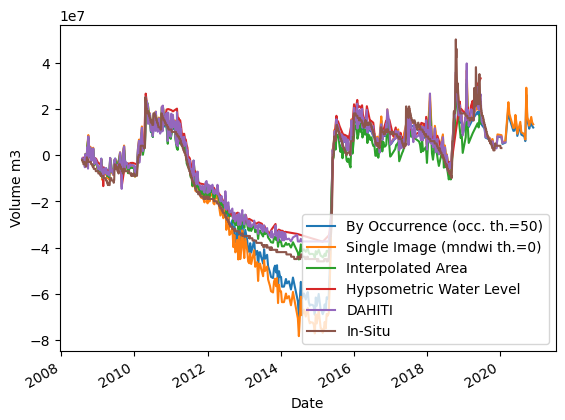

In [72]:
insitu = pd.read_csv('Data/insitu_volume.csv',header=None,sep=";")
ts = pd.Series(insitu.loc[:,1] * 1e9)
ts.index = pd.DatetimeIndex(insitu.loc[:,0]).rename("Date")
insitu = ts[ts.index >= variable_volume.index.min()]
insitu = insitu - (insitu.iloc[0] - variable_volume.iloc[0])
insitu.plot(ax=ax1,label="In-Situ")
ax1.legend()
fig1